# Difference-in-difference: do higher wages lead to job losses? 

This notebook is a tutorial on __[difference-in-differences](https://en.wikipedia.org/wiki/Difference_in_differences)__ , a __[causal inference](https://en.wikipedia.org/wiki/Causal_inference)__ method, often used in econometrics. 

The example follows the study by Card, D., & Krueger, A. B. (1993). *Minimum wages and employment: A case study of the fast food industry in New Jersey and Pennsylvania* (Working Paper No. 4509). National Bureau of Economic Research. http://www.nber.org/papers/w4509

In April '92, New Jersey passed the law to increase the minimum wage to \$5 per hour. The economists Card and Krueger examined the effects of the law on employment. The conventional economic theory at the time was that increasing the minimum wage would lead employers to cut to cut jobs, resulting in a higher unemployment rate.

The study examined 410 fast-food restaurants in New Jersey and Philadelphia (which didn't increase its minimum wage) before and after April '92 and used the difference-in-differences method to examine the causal relationship between minimum wages and employment. 

The study found no statistically significant employment reduction after New Jersey increased its minimum wage. 
On the contrary, it found that employment in New Jersey's fast-food sector actually increased slightly relative to Pennsylvania's, although this difference was not statistically significant. These findings have fundamentally shaped the understanding of how economic policies affect individuals and markets.

__[David Card](https://davidcard.berkeley.edu)__ was one of three recipients of the __[Nobel Prize for Economics in 2021](https://www.nobelprize.org/prizes/economic-sciences/2021/card/facts/)__ for his contributions to empirical microeconomics, especially labor economics.

## Data source for this notebook

This is the original data, as used in __[Dr. Paul C. Bauer](https://paulcbauer.github.io//)__'s course __["Applied Causal Analysis (with R)"](https://bookdown.org/paul/applied-causal-analysis/)__ at the University of Mannheim. The variable names are renamed for easier use.

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# load data
data = pd.read_csv("") # data path

In [3]:
# dataset statistics
data.describe()

,x_co_owned,x_southern_nj,x_central_nj,x_northeast_philadelphia,x_easton_philadelphia,x_st_wage_before,x_st_wage_after,x_hrs_open_weekday_before,x_hrs_open_weekday_after,y_ft_employment_before,y_ft_employment_after,d_nj,d_pa,x_burgerking,x_kfc,x_roys,x_wendys,x_closed_permanently
count,410.000000,410.000000,410.000000,410.000000,410.000000,390.000000,389.000000,410.000000,399.000000,398.000000,396.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,0.343902,0.226829,0.153659,0.087805,0.104878,4.615641,4.996272,14.439024,14.465539,20.998869,21.054293,0.807317,0.192683,0.417073,0.195122,0.241463,0.146341,0.014634
std,0.475589,0.419293,0.361062,0.283357,0.306771,0.347015,0.253190,2.809987,2.752495,9.749805,9.094453,0.394888,0.394888,0.493678,0.396779,0.428493,0.353880,0.120230
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.250000,4.250000,7.000000,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.250000,5.050000,12.000000,12.000000,14.562500,14.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,5.050000,15.500000,15.000000,19.500000,20.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,4.950000,5.050000,16.000000,16.000000,24.500000,26.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.750000,6.250000,24.000000,24.000000,85.000000,60.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable description

```
y_ft_employment_before: Full time equivalent employment (FTE) before treatment [Outcome]
y_ft_employment_after: Full time equivalent employment (FTE) after treatment [Outcome]
d_nj: 1 if New Jersey; 0 if Pennsylvania (treatment variable) [Treatment]
d_pa: 1 if Pennsylvania; 0 if New Jersey (control variable)
x_co_owned: If owned by company = 1
x_southern_nj: If in southern NJ = 1
x_central_nj: If if in central NJ = 1
x_northeast_philadelphia: If in Pennsylvania, northeast suburbs of Philadelphia = 1
x_easton_philadelphia: If in Pennsylvania, Easton = 1
x_st_wage_before: Starting wage ($/hr) before treatment 
x_st_wage_after: Starting wage ($/hr) after treatment 
x_burgerking: If Burgerking = 1
x_kfc: If KFC = 1
x_roys: If Roys = 1
x_wendys: If Wendys = 1
x_closed_permanently: Closed permanently after treatment
```

In [4]:
# display the dataset
data

,x_co_owned,x_southern_nj,x_central_nj,x_northeast_philadelphia,x_easton_philadelphia,x_st_wage_before,x_st_wage_after,x_hrs_open_weekday_before,x_hrs_open_weekday_after,y_ft_employment_before,y_ft_employment_after,d_nj,d_pa,x_burgerking,x_kfc,x_roys,x_wendys,x_closed_permanently
0,0,0,0,1,0,NaN,4.30,16.5,16.5,40.50,24.00,0,1,1,0,0,0,0
1,0,0,0,1,0,NaN,4.45,13.0,13.0,13.75,11.50,0,1,0,1,0,0,0
2,1,0,0,1,0,NaN,5.00,10.0,11.0,8.50,10.50,0,1,0,1,0,0,0
3,1,0,0,1,0,5.00,5.25,12.0,12.0,34.00,20.00,0,1,0,0,0,1,0
4,1,0,0,1,0,5.50,4.75,12.0,12.0,24.00,35.50,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,1,0,0,0,0,4.95,5.25,12.0,11.0,9.00,23.75,1,0,0,1,0,0,0
406,1,0,0,0,0,4.75,5.25,11.0,14.0,9.75,17.50,1,0,0,1,0,0,0
407,1,0,0,0,0,4.25,5.05,19.0,18.0,24.50,20.50,1,0,0,0,1,0,0
408,0,0,0,0,0,4.75,5.05,12.5,12.5,14.00,20.50,1,0,0,0,0,1,0


In [5]:
# check for NaN values

data.isnull().any()

x_co_owned                   False
x_southern_nj                False
x_central_nj                 False
x_northeast_philadelphia     False
x_easton_philadelphia        False
x_st_wage_before              True
x_st_wage_after               True
x_hrs_open_weekday_before    False
x_hrs_open_weekday_after      True
y_ft_employment_before        True
y_ft_employment_after         True
d_nj                         False
d_pa                         False
x_burgerking                 False
x_kfc                        False
x_roys                       False
x_wendys                     False
x_closed_permanently         False
dtype: bool

In [6]:
# Interpolating NaNs

missing_values = SimpleImputer(missing_values = np.nan, 
                               strategy = 'mean')
missing_values = missing_values.fit(data[['x_st_wage_before',
                                          'x_st_wage_after', 
                                          'x_hrs_open_weekday_after', 
                                          'y_ft_employment_before',
                                          'y_ft_employment_after']])
data[['x_st_wage_before',
      'x_st_wage_after', 
      'x_hrs_open_weekday_after', 
      'y_ft_employment_before',
      'y_ft_employment_after']] = missing_values.transform(data[['x_st_wage_before',
                                                                 'x_st_wage_after', 
                                                                 'x_hrs_open_weekday_after', 
                                                                 'y_ft_employment_before',
                                                                 'y_ft_employment_after']])
data.isnull().any().sum() # check for NaNs again

0

## Exploratory Data Analysis

In [7]:
# defining some variables
fte_nj_pre92 = data[data["d_nj"] == 1]["y_ft_employment_before"]
fte_nj_post92 = data[data["d_nj"] == 1]["y_ft_employment_after"]

fte_pa_pre92 = data[data["d_pa"] == 1]["y_ft_employment_before"]
fte_pa_post92 = data[data["d_pa"] == 1]["y_ft_employment_after"]

wage_nj_pre92 = data[data["d_nj"] == 1]["x_st_wage_before"]
wage_nj_post92 = data[data["d_nj"] == 1]["x_st_wage_after"]

wage_pa_pre92 = data[data["d_pa"] == 1]["x_st_wage_before"]
wage_pa_post92 = data[data["d_pa"] == 1]["x_st_wage_after"]

hrs_open_weekday_nj_pre92 = data[data["d_nj"] == 1]["x_hrs_open_weekday_before"]
hrs_open_weekday_nj_post92 = data[data["d_nj"] == 1]["x_hrs_open_weekday_after"]

hrs_open_weekday_pa_pre92 = data[data["d_pa"] == 1]["x_hrs_open_weekday_before"]
hrs_open_weekday_pa_post92 = data[data["d_pa"] == 1]["x_hrs_open_weekday_after"]

In [8]:
# dispaly statistics for FTE for New Jersey and Pennsylvania

print("FTE NJ, before 92:\nsize:", fte_nj_pre92.shape, "\nmean:", fte_nj_pre92.values.mean(), "\nmax:", fte_nj_pre92.values.max(), "\nmin:", fte_nj_pre92.values.min())
print('-----------------------------')
print("FTE NJ, after 92:\nsize:", fte_nj_post92.shape, "\nmean:", fte_nj_post92.values.mean(), "\nmax:", fte_nj_post92.values.max(), "\nmin:", fte_nj_post92.values.min())
print('-----------------------------')
print("FTE PA, before 92:\nsize:", fte_pa_pre92.shape, "\nmean:", fte_pa_pre92.values.mean(), "\nmax:", fte_pa_pre92.values.max(), "\nmin:", fte_pa_pre92.values.min())
print('-----------------------------')
print("FTE PA, after 92:\nsize:", fte_pa_post92.shape, "\nmean:", fte_pa_post92.values.mean(), "\nmax:", fte_pa_post92.values.max(), "\nmin:", fte_pa_post92.values.min())

FTE NJ, before 92:
size: (331,) 
mean: 20.45631025216718 
max: 85.0 
min: 5.0
-----------------------------
FTE NJ, after 92:
size: (331,) 
mean: 21.02840336903781 
max: 60.5 
min: 0.0
-----------------------------
FTE PA, before 92:
size: (79,) 
mean: 23.272123274600855 
max: 70.5 
min: 7.5
-----------------------------
FTE PA, after 92:
size: (79,) 
mean: 21.162766909602354 
max: 43.5 
min: 0.0


In [9]:
# dispaly wage statistics for New Jersey and Pennsylvania

print("Wages NJ, before 92:\nsize:", wage_nj_pre92.shape, "\nmean:", wage_nj_pre92.values.mean(), "\nmax:", wage_nj_pre92.values.max(), "\nmin:", wage_nj_pre92.values.min())
print('-----------------------------')
print("Wages NJ, after 92:\nsize:", wage_nj_post92.shape, "\nmean:", wage_nj_post92.values.mean(), "\nmax:", wage_nj_post92.values.max(), "\nmin:", wage_nj_post92.values.min())
print('-----------------------------')
print("Wages PA, before 92:\nsize:", wage_pa_pre92.shape, "\nmean:", wage_pa_pre92.values.mean(), "\nmax:", wage_pa_pre92.values.max(), "\nmin:", wage_pa_pre92.values.min())
print('-----------------------------')
print("Wages PA, after 92:\nsize:", wage_pa_post92.shape, "\nmean:", wage_pa_post92.values.mean(), "\nmax:", wage_pa_post92.values.max(), "\nmin:", wage_pa_post92.values.min())

Wages NJ, before 92:
size: (331,) 
mean: 4.612313889534433 
max: 5.75 
min: 4.25
-----------------------------
Wages NJ, after 92:
size: (331,) 
mean: 5.077527318478707 
max: 5.75 
min: 4.996272493573264
-----------------------------
Wages PA, before 92:
size: (79,) 
mean: 4.629581304771179 
max: 5.5 
min: 4.25
-----------------------------
Wages PA, after 92:
size: (79,) 
mean: 4.65582506264033 
max: 6.25 
min: 4.25


### Figure 1: Plotting wages

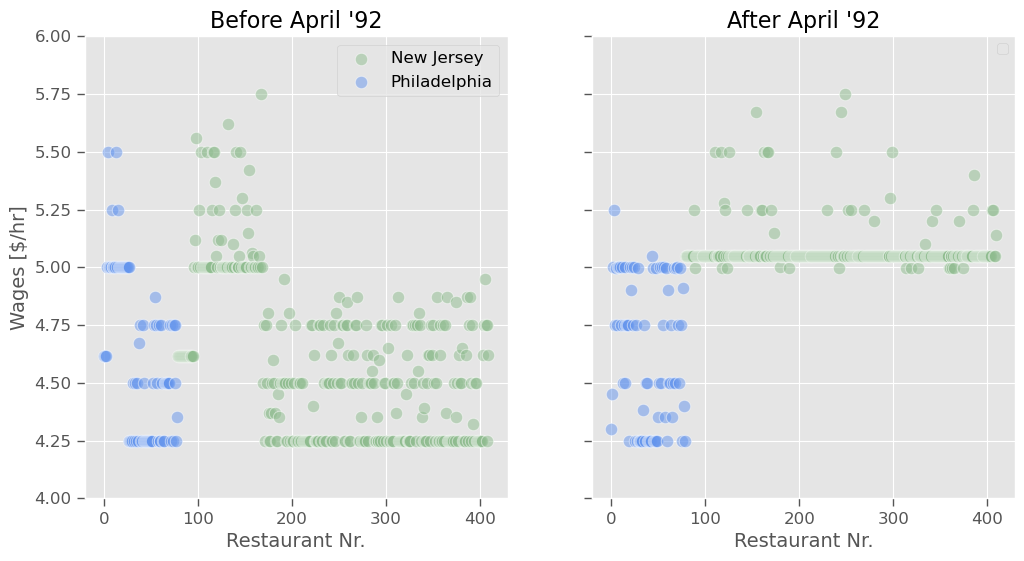

In [24]:
# limits for y axes for both plots
max_y_up = max(max(fte_nj_pre92), max(fte_pa_pre92), max(fte_nj_post92), max(fte_nj_post92))
max_y_down = max(max(wage_nj_pre92), max(wage_pa_pre92), max(wage_nj_post92), max(wage_nj_post92))
min_y_down = min(min(wage_nj_pre92), min(wage_pa_pre92), min(wage_nj_post92), min(wage_nj_post92))

fig, axs = plt. subplots(1,2)
plt.rcParams['figure.figsize'] = [12, 6]

sns.scatterplot(wage_nj_pre92, s=80, label="New Jersey", ax=axs[0], color='darkseagreen', alpha=0.5)
sns.scatterplot(wage_pa_pre92, s=80, label="Philadelphia", ax=axs[0], color='cornflowerblue', alpha=0.5)
axs[0].set_title("Before April '92", fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0].tick_params(axis='y', left = True, labelleft=True)
axs[0].set_xlabel("Restaurant Nr.", fontsize=14)
axs[0].set_ylabel("Wages [$/hr]", fontsize=14)
axs[0].set_ylim(min_y_down-0.25, max_y_down+0.25)
axs[0].legend(fontsize=12)

sns.scatterplot(wage_nj_post92, s=80, label="New Jersey", ax=axs[1], color='darkseagreen', alpha=0.5)
sns.scatterplot(wage_pa_post92, s=80, label="Philadelphia", ax=axs[1], color='cornflowerblue', alpha=0.5)
axs[1].set_title("After April '92", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1, labelleft=False)
axs[1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1].tick_params(axis='y', left = True, labelleft=False)
axs[1].set_xlabel("Restaurant Nr.", fontsize=14)
axs[1].set_ylabel('')
axs[1].set_ylim(min_y_down-0.25, max_y_down+0.25)
axs[1].legend('')

**Figure 1:** The wage difference between New Jersey (green circles) and Philadelphia (blue circles) before and after April '92 is strikingly noticeable. In the left panel, most restaurants in New Jersey had wages similar to those in Philadelphia. However, in the right panel, there is a significant increase, particularly at 5\$/hour in New Jersey.

### Figure 2: plotting histograms of wages and FTE

Text(0, 0.5, '')

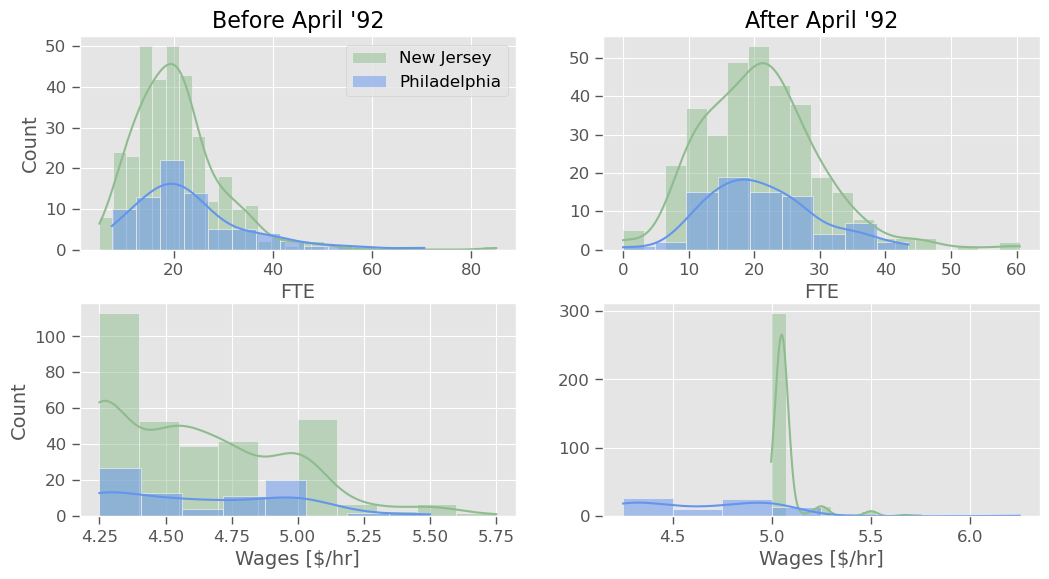

In [11]:
warnings.filterwarnings('ignore')

fig, axs = plt. subplots(2,2)
plt.rcParams['figure.figsize'] = [14, 10]
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.25)

sns.histplot(fte_nj_pre92, kde=True, label="New Jersey", ax=axs[0, 0], color='darkseagreen')
sns.histplot(fte_pa_pre92, kde=True, label="Philadelphia", ax=axs[0, 0], color='cornflowerblue')
axs[0,0].set_title("Before April '92", fontsize=16)
axs[0,0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0,0].legend(fontsize=12)
axs[0,0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0,0].tick_params(axis='y', left = True, labelleft=True)
axs[0,0].set_xlabel('FTE', fontsize=14)
axs[0,0].set_ylabel('Count', fontsize=14)

sns.histplot(fte_nj_post92, kde=True, label="New Jersey", ax=axs[0, 1], color='darkseagreen')
sns.histplot(fte_pa_post92, kde=True, label="Philadelphia", ax=axs[0, 1], color='cornflowerblue')
axs[0,1].set_title("After April '92", fontsize=16)
axs[0,1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0,1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0,1].tick_params(axis='y', left = True, labelleft=True)
axs[0,1].set_xlabel('FTE', fontsize=14)
axs[0,1].set_ylabel('')

sns.histplot(wage_nj_pre92, kde=True, label="New Jersey", ax=axs[1, 0], color='darkseagreen')
sns.histplot(wage_pa_pre92, kde=True, label="Philadelphia", ax=axs[1, 0], color='cornflowerblue')
axs[1,0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[1,0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1,0].tick_params(axis='y', left = True, labelleft=True)
axs[1,0].set_xlabel('Wages [$/hr]', fontsize=14)
axs[1,0].set_ylabel('Count', fontsize=14)

sns.histplot(wage_nj_post92, kde=True, label="New Jersey", ax=axs[1, 1], color='darkseagreen')
sns.histplot(wage_pa_post92, kde=True, label="Philadelphia", ax=axs[1, 1], color='cornflowerblue')
axs[1,1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[1,1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1,1].tick_params(axis='y', left = True, labelleft=True)
axs[1,1].set_xlabel('Wages [$/hr]', fontsize=14)
axs[1,1].set_ylabel('')

**Figure 2:** Upper row shows distributions of FTE for New Jersey (green) and Philadelphia (blue), while lower row shows distributions of wages. Before the increase (left panel), wage distributions in New Jersey mirrored those in Philadelphia. Following the change, a noticeable shift in New Jersey's distribution is evident (right panel). The disparity between New Jersey and Philadelphia is particularly pronounced in the wage histograms, as anticipated.

### Figure 3: plotting the relationship between FTE and wages before April '92 in a jointplot

Text(37.597222222222214, 0.5, 'FTE')

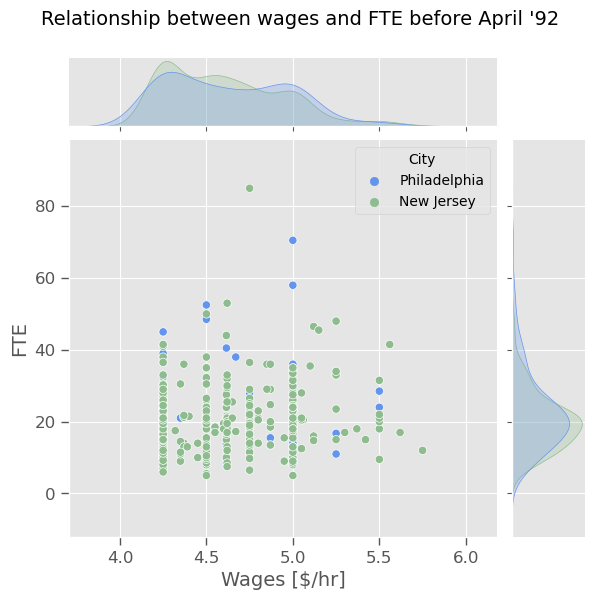

In [25]:
# slicing data just for plotting
nj_mapping = {0: "Philadelphia", 1: "New Jersey"}
data_plot = data[["y_ft_employment_before", "x_st_wage_before", "d_nj"]].copy()
data_plot['d_nj'] = data_plot['d_nj'].map(nj_mapping)
data_plot = data_plot.rename(columns={'d_nj': 'City'})

# defining the color palette
palette = {"Philadelphia": 'cornflowerblue', "New Jersey": 'darkseagreen'}

sns.jointplot(data=data_plot, 
              x="x_st_wage_before", y="y_ft_employment_before", 
              kind='scatter', marginal_kws=dict(fill=True, common_norm=False), 
              hue="City", palette=palette)

plt.subplots_adjust(top=0.9) 
plt.suptitle("Relationship between wages and FTE before April '92", fontsize=14)
plt.xlabel("Wages")
plt.ylabel("FTE")
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.xlabel('Wages [$/hr]', fontsize=14)
plt.ylabel('FTE', fontsize=14)

**Figure 3:** The bivariate graph (middle plot) above shows the relationship between FTE and wages **before April '92** for New Jersey (green) and Philadelphia (blue). Most data points cluster in the lower left corner, indicating that wages in both cities are below `$5/hr` for FTEs below 40 (i.e., a typical full work week). The plot above shows the distribution of wages for both cities, while the plot on the right shows the distribution of FTE. The wage distribution for New Jersey (green) is skewed towards lower wages, whereas the wage distribution for Philadelphia (blue) is more spread out. The FTE distribution for both cities is similar, centered around an FTE of 20.

### Figure 4: plotting the relationship between FTE and wages after April '92 in a jointplot

Text(37.597222222222214, 0.5, 'FTE')

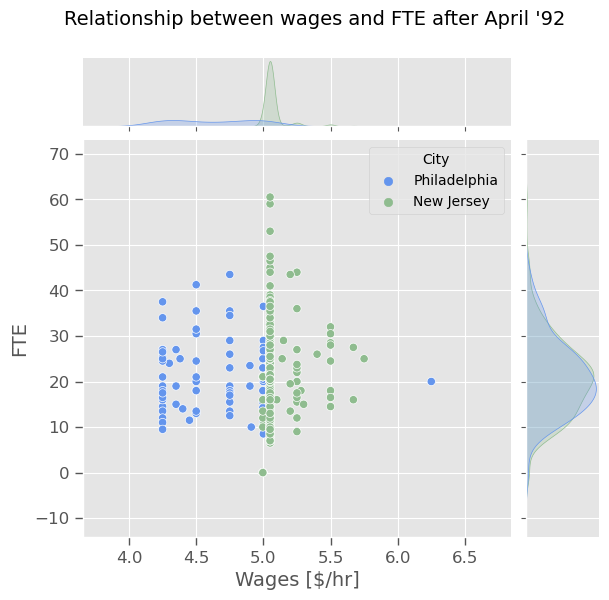

In [26]:
# slicing data just for plotting
nj_mapping = {0: "Philadelphia", 1: "New Jersey"}
data_plot = data[["y_ft_employment_after", "x_st_wage_after", "d_nj"]].copy()
data_plot['d_nj'] = data_plot['d_nj'].map(nj_mapping)
data_plot = data_plot.rename(columns={'d_nj': 'City'})

# defining the color palette
palette = {"Philadelphia": 'cornflowerblue', "New Jersey": 'darkseagreen'}

sns.jointplot(data=data_plot, 
              x="x_st_wage_after", y="y_ft_employment_after", 
              kind='scatter', marginal_kws=dict(fill=True, common_norm=False), 
              hue="City", palette=palette)

plt.subplots_adjust(top=0.9) 
plt.suptitle("Relationship between wages and FTE after April '92", fontsize=14)
plt.xlabel("Wages")
plt.ylabel("FTE")
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.xlabel('Wages [$/hr]', fontsize=14)
plt.ylabel('FTE', fontsize=14)

**Figure 4:** On this bivariate graph (middle plot), the relationship between FTE and wages **after April '92** looks distinctly different. New Jersey (green) data points are clustered on the right, while those for Philadelphia (blue) are clustered on the left, showing a clear separation above `$5/hr`. This pattern is similar to the wage distribution for both cities (upper plot). The distribution for New Jersey is clearly centered on $5/hr, while the distribution for Philadelphia remains uniform. The distribution of FTE on the right for both cities looks similar to the distribution before the wage increase, i.e., it is still centered around an FTE of 20. The authors of the __[paper](http://www.nber.org/papers/w4509)__ set the FTE of closed restaurants to 0.

## Difference-in-differences method

Difference-in-differences method is a statistical technique most commonly used in econometrics and social sciences. It estimates the causal effect of a treatment or an intervention. It is often used in longitudinal studies, where it's impossible to implement __[randomized controlled trials](https://en.wikipedia.org/wiki/Randomized_controlled_trial)__ directly. Instead, we have a __[natural experiment](https://en.wikipedia.org/wiki/Natural_experiment)__, a treatment group, and a control group. The method examines differences in outcome before and after the treatment in both groups. It assumes that any changes in the control group reflect what would have happened to the treatment group without intervention. This way, the method controls for confounding factors and isolates the treatment effect. Linear and logistic regression are often used for prediction with difference-in-difference method. 

More about differences-in-differences method can be found __[here](https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation)__ and __[here](https://www.sciencedirect.com/topics/economics-econometrics-and-finance/difference-in-differences#:~:text=The%20difference%2Din%2Ddifference%20method,is%20exposed%20to%20a%20treatment.)__.

In our case, we are interested in difference in employment **after** wages increased in New Jersey. The treatment group is New Jersey, the control group is Philadelphia and the outcome variable is FTE. **If** higher wages lead to job losses, we would expect to see that the treatment variable (New Jersey) in the linear regression is **statistically significant**, i.e. p-value should be smaller than 0.05.

In [14]:
#slicing data
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after']]
Y = data.loc[:,'y_ft_employment_after'] - data.loc[:,'y_ft_employment_before']  # differences in fte/employment

### Model 1

As a starting point, we use the simplest model. We predict FTE from wages and account for the treatment variable. If the wage increase in New Jersey has a significant effect on employment, we would expect the treatment variable to be statistically significant.

In [15]:
# model 1
X = sm.add_constant(X)
model1 = sm.OLS(Y, X).fit()
model1.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.771
Date:                Fri, 12 Jul 2024   Prob (F-statistic):             0.0413
Time:                        11:58:43   Log-Likelihood:                -1470.5
No. Observations:                 410   AIC:                             2949.
Df Residuals:                     406   BIC:                             2965.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.2798     11.705      0.366      0.715     -18.730      27.290
New Jersey       2.3776      1.512      1.572      0.117      -0.595       5.350
Wages before    -2.0216      1.317     -1.535      0.125      -4.610       0.567
Wages after      0.6379      2.449      0.260      0.795      -4.177       5.453
==============================================================================
Omnibus:                       36.089   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.712
Skew:                          -0.370   Prob(JB):                     1.11e-23
Kurtosis:                       5.375   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

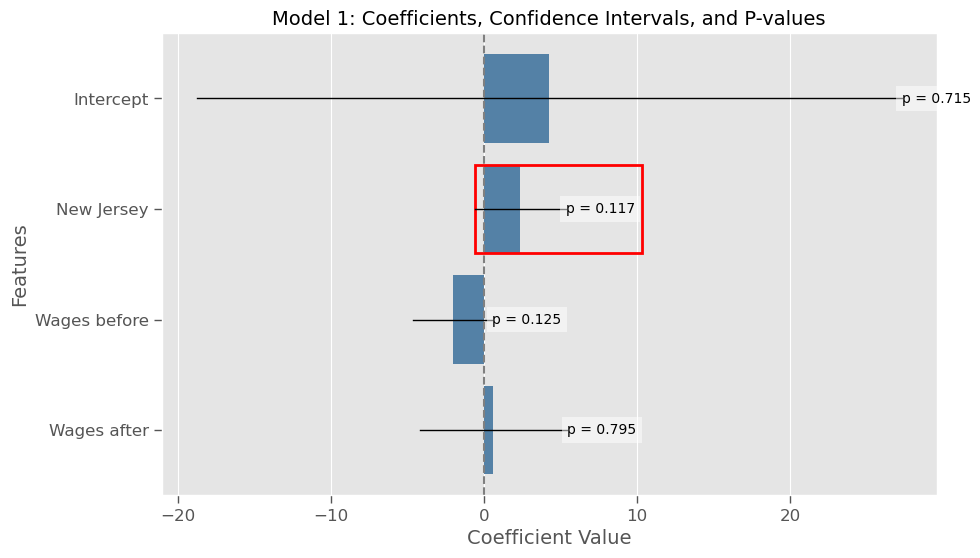

In [16]:
# Plot regression coefficients
# Extract the coefficients and p-values
coefficients1 = model1.params
conf1_int = model1.conf_int()
conf1_int.columns = ['CI Lower', 'CI Upper']
p_values1 = model1.pvalues
feature_names1 = ["Intercept", "New Jersey", "Wages before", "Wages after"]

# Combine coefficients and confidence intervals into a single DataFrame
coef1_df = pd.concat([coefficients1, conf1_int, p_values1], axis=1)
coef1_df.columns = ['Coefficient', 'CI Lower', 'CI Upper', 'P-value']
coef1_df.index.name = 'Feature'
coef1_df.reset_index(inplace=True)

# Plot the coefficients using Seaborn
plt.subplots(figsize=(10, 6))

bar_color = 'steelblue'
sns.barplot(x='Coefficient', y=feature_names1, data=coef1_df, color=bar_color, orient='h', linewidth=0.5)

for index, row in coef1_df.iterrows():
    plt.plot([row['CI Lower'], row['CI Upper']], [index, index], 'k-', lw=1)  
    plt.text(row['CI Upper'], index, f'p = {row["P-value"]:.3f}', va='center', ha='left', fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    if row["Feature"]=='d_nj':
        rect = plt.Rectangle((row['CI Lower'], index - 0.4), row['CI Upper'] - row['CI Lower']+5, 0.8,
                  fill=None, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Model 1: Coefficients, Confidence Intervals, and P-values', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.show()

**Figure 5:** This figure displays the coefficients for each feature of the Model 1, along with their p-values. The New Jersey variable or the treatment variable is highlighted in red. We observe that the New Jersey variable is not statistically significant.

### Model 2

Although Model 1 shows no significant effect of increasing wages on the prediction of FTE, this might be because Model 1 is too simple. In Model 1, we pooled all types of restaurants together, but there might be differences in the effects of wage increases between KFC and Burger King. We expand Model 2 to include different fast-food chains to account for such differences. We now use wages, the treatment variable, and variables for Burger King, KFC, and Wendy's to predict FTE. To avoid the effects of __[multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)__, we drop an encoding variable for one fast-food restaurant, in this case, Roy's.

In [17]:
# model 2
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys']]      # defining X; Y stays the same
X = sm.add_constant(X)

model2 = sm.OLS(Y, X).fit() 
model2.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.354
Date:                Fri, 12 Jul 2024   Prob (F-statistic):             0.0302
Time:                        11:58:43   Log-Likelihood:                -1467.6
No. Observations:                 410   AIC:                             2949.
Df Residuals:                     403   BIC:                             2977.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2431     11.872      0.189      0.850     -21.095      25.581
New Jersey       2.5855      1.516      1.706      0.089      -0.394       5.565
Wages before    -1.6649      1.348     -1.235      0.218      -4.315       0.985
Wages after      0.3163      2.450      0.129      0.897      -4.500       5.133
Burger King      2.2520      1.125      2.003      0.046       0.041       4.463
KFC              2.6647      1.322      2.015      0.045       0.065       5.264
Wendys           2.5290      1.441      1.755      0.080      -0.305       5.363
==============================================================================
Omnibus:                       41.224   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.734
Skew:                          -0.436   Prob(JB):                     2.23e-27
Kurtosis:                       5.535   Cond. No.                         194.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

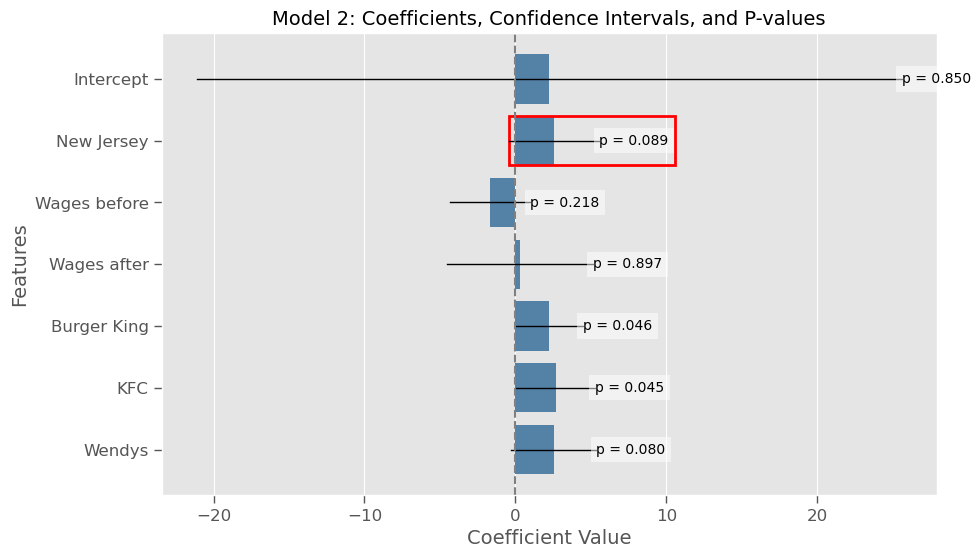

In [18]:
# Plot regression coefficients
# Extract the coefficients and p-values
coefficients2 = model2.params
conf2_int = model2.conf_int()
conf2_int.columns = ['CI Lower', 'CI Upper']
p_values2 = model2.pvalues
feature_names2 = ["Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys']

# Combine coefficients and confidence intervals into a single DataFrame
coef2_df = pd.concat([coefficients2, conf2_int, p_values2], axis=1)
coef2_df.columns = ['Coefficient', 'CI Lower', 'CI Upper', 'P-value']
coef2_df.index.name = 'Feature'
coef2_df.reset_index(inplace=True)

# Plot the coefficients using Seaborn
plt.subplots(figsize=(10, 6))

bar_color = 'steelblue'
sns.barplot(x='Coefficient', y=feature_names2, data=coef2_df, color=bar_color, orient='h', linewidth=0.5)

for index, row in coef2_df.iterrows():
    plt.plot([row['CI Lower'], row['CI Upper']], [index, index], 'k-', lw=1)  
    plt.text(row['CI Upper'], index, f'p = {row["P-value"]:.3f}', va='center', ha='left', fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    if row["Feature"]=='d_nj':
        rect = plt.Rectangle((row['CI Lower'], index - 0.4), row['CI Upper'] - row['CI Lower']+5, 0.8,
                  fill=None, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Model 2: Coefficients, Confidence Intervals, and P-values', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.show()

**Figure 6:** This figure presents the coefficients for each feature of the Model 2, along with their p-values. The New Jersey variable, also known as the treatment variable, is highlighted in red. Once more, we observe that the New Jersey variable is not statistically significant. The value of the coefficient for New Jersey is similar to the value in Model 1 (2.5855 for Model 2 and 2.3776 for Model 1). Adding variables for fast food chains doesn't seem to improve the model.

### Model 3

Since expanding the model with variables for different fast food chains doesn't improve it, it might be better to account for regional differences within New Jersey. In Model 3, we no longer account for fast food chains. Instead, we add variables for southern and central New Jersey.

In [19]:
# model 3
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after', 'x_southern_nj', 'x_central_nj']]  # defining X; Y stays the same
X = sm.add_constant(X)

model3 = sm.OLS(Y, X).fit()
model3.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Southern NJ', 'Central NJ'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.819
Date:                Fri, 12 Jul 2024   Prob (F-statistic):              0.108
Time:                        11:58:44   Log-Likelihood:                -1470.1
No. Observations:                 410   AIC:                             2952.
Df Residuals:                     404   BIC:                             2976.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.1444     11.748      0.353      0.724     -18.950      27.238
New Jersey       2.6716      1.584      1.686      0.093      -0.443       5.786
Wages before    -2.0008      1.325     -1.511      0.132      -4.605       0.603
Wages after      0.6463      2.453      0.263      0.792      -4.177       5.469
Southern NJ     -0.2720      1.133     -0.240      0.810      -2.500       1.956
Central NJ      -1.1603      1.292     -0.898      0.370      -3.700       1.380
==============================================================================
Omnibus:                       35.266   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.310
Skew:                          -0.365   Prob(JB):                     1.00e-22
Kurtosis:                       5.323   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

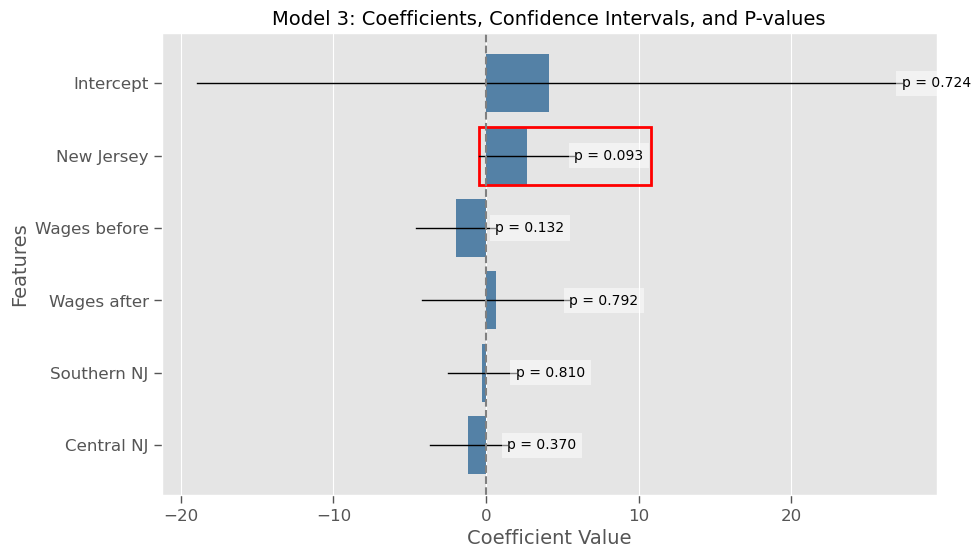

In [20]:
# Plot regression coefficients
# Extract the coefficients and p-values
coefficients3 = model3.params
conf3_int = model3.conf_int()
conf3_int.columns = ['CI Lower', 'CI Upper']
p_values3 = model3.pvalues
feature_names3 = ["Intercept", "New Jersey", "Wages before", "Wages after", 
                  'Southern NJ', 'Central NJ']

# Combine coefficients and confidence intervals into a single DataFrame
coef3_df = pd.concat([coefficients3, conf3_int, p_values3], axis=1)
coef3_df.columns = ['Coefficient', 'CI Lower', 'CI Upper', 'P-value']
coef3_df.index.name = 'Feature'
coef3_df.reset_index(inplace=True)

# Plot the coefficients using Seaborn
plt.subplots(figsize=(10, 6))

bar_color = 'steelblue'
sns.barplot(x='Coefficient', y=feature_names3, data=coef3_df, color=bar_color, orient='h', linewidth=0.5)

for index, row in coef3_df.iterrows():
    plt.plot([row['CI Lower'], row['CI Upper']], [index, index], 'k-', lw=1)  
    plt.text(row['CI Upper'], index, f'p = {row["P-value"]:.3f}', va='center', ha='left', fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    if row["Feature"]=='d_nj':
        rect = plt.Rectangle((row['CI Lower'], index - 0.4), row['CI Upper'] - row['CI Lower']+5, 0.8,
                  fill=None, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Model 3: Coefficients, Confidence Intervals, and P-values', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.show()

**Figure 7:** This figure shows the coefficients for each feature of Model 3 and their p-values. Once again, we observe that the New Jersey variable (highlighted in red) is not statistically significant. The value of the coefficient for New Jersey is similar to that in previous models (2.6716). It appears that neither accounting for regional differences nor including fast food chains improves the model, as these adjustments do not lead to better predictions of FTE.

### Model 4

So far, neither model has shown a significant effect of wage increases on employment. One hypothesis is that after the wage increase, employers might cut working hours. To check for that effect, in Model 4 we include variables for different opening hours, in addition to wages and the treatment variable, to predict FTE.

In [21]:
# model 4
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_hrs_open_weekday_before', 'x_hrs_open_weekday_after']]      # defining X; Y stays the same
X = sm.add_constant(X)

model4 = sm.OLS(Y, X).fit()
model4.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                        'Hours open weekday before', 'Hours open weekday after'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.064
Date:                Fri, 12 Jul 2024   Prob (F-statistic):            0.00997
Time:                        11:58:44   Log-Likelihood:                -1467.0
No. Observations:                 410   AIC:                             2946.
Df Residuals:                     404   BIC:                             2970.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.8573     11.989      0.405      0.686     -18.711      28.425
New Jersey                    2.3863      1.503      1.587      0.113      -0.569       5.341
Wages before                 -2.0018      1.310     -1.528      0.127      -4.577       0.573
Wages after                   0.8637      2.438      0.354      0.723      -3.928       5.656
Hours open weekday before    -1.0761      0.419     -2.570      0.011      -1.899      -0.253
Hours open weekday after      0.9494      0.434      2.188      0.029       0.096       1.802
==============================================================================
Omnibus:                       37.990   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.993
Skew:                          -0.381   Prob(JB):                     6.49e-26
Kurtosis:                       5.492   Cond. No.                         619.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

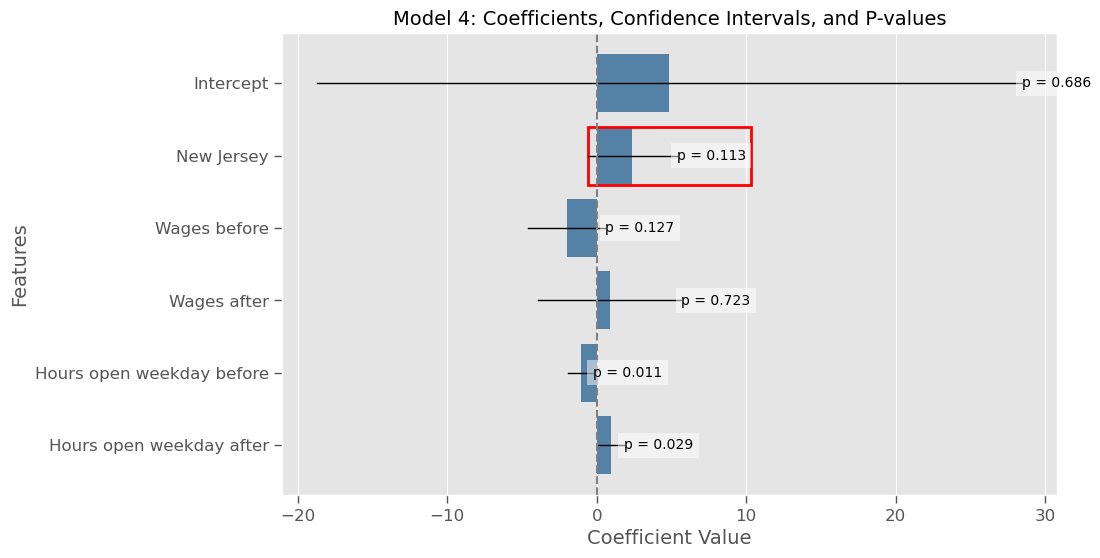

In [22]:
# Plot regression coefficients
# Extract the coefficients and p-values
coefficients4 = model4.params
conf4_int = model4.conf_int()
conf4_int.columns = ['CI Lower', 'CI Upper']
p_values4 = model4.pvalues
feature_names4 = ["Intercept", "New Jersey", "Wages before", "Wages after", 
                  'Hours open weekday before', 'Hours open weekday after']

# Combine coefficients and confidence intervals into a single DataFrame
coef4_df = pd.concat([coefficients4, conf4_int, p_values4], axis=1)
coef4_df.columns = ['Coefficient', 'CI Lower', 'CI Upper', 'P-value']
coef4_df.index.name = 'Feature'
coef4_df.reset_index(inplace=True)

# Plot the coefficients using Seaborn
plt.subplots(figsize=(10, 6))

bar_color = 'steelblue'
sns.barplot(x='Coefficient', y=feature_names4, data=coef4_df, color=bar_color, orient='h', linewidth=0.5)

for index, row in coef4_df.iterrows():
    plt.plot([row['CI Lower'], row['CI Upper']], [index, index], 'k-', lw=1)  
    plt.text(row['CI Upper'], index, f'p = {row["P-value"]:.3f}', va='center', ha='left', fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    if row["Feature"]=='d_nj':
        rect = plt.Rectangle((row['CI Lower'], index - 0.4), row['CI Upper'] - row['CI Lower']+5, 0.8,
                  fill=None, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)

plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Model 4: Coefficients, Confidence Intervals, and P-values', fontsize=14)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.show()

**Figure 8:** Similar to the previous figures, we see the coefficients for each feature of Model 4 and their p-values. Once again, we observe that the New Jersey variable (highlighted in red) is not statistically significant. The value of the coefficient for New Jersey is similar to that in previous models (2.3863). Accounting for opening hours also does not lead to better predictions of FTE.

## Conclusion

In this notebook, we've shown a use case for difference-in-difference method. Card and Kruger in their __[study](http://www.nber.org/papers/w4509)__ go into more detail and show more models, neither of which the treatment variable is statistically significant. They show that with an increase in the minimum wage in  New Jersey from \$4.25/hour to \$5.05/hour per hour, there was no increase in job losses in New Jersey relative to Pennsylvania, where the minimum wage remained unchanged.

This challenged the conventional economic theory at the time. Further, the paper shows that employment slightly increased in New Jersey compared to Pennsylvania, but the increase was not statistically significant. The results suggest that the impact of minimum wage increases on employment is more complex and less negative than previously thought.